In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#! ls

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import warnings
#warnings.filterwarnings('ignore')
from scipy.special import expit
import decimal

sns.set_style("whitegrid")
parent_path = "./"

if not os.path.exists(parent_path+"/Batch-Loss-Charts"):
    os.makedirs(parent_path+"/Batch-Loss-Charts")
    
save_path = parent_path + "/Batch-Loss-Charts/Ite-{0}-Batch-{1}.png"


In [ ]:
def read_data(path="./data.txt"):
    file = open(path, "r")
    users = []
    users_count = 0
    
    items = set([])
    items_count = 0
    
    for line in tqdm(file.readlines()):
        if line != "":
            users_count += 1
            line = list(line.split())
            users.append(list(map(int,line[1:])))
            items.update(set(users[-1]))
            
    items_count = len(items)
    items = list(items)
    items.sort()
    R = np.zeros((items_count, users_count), dtype=np.float32)
    print("Matrix R Creation")
    for user_index, user in tqdm(enumerate(users)):
        for item in user:
            R[item, user_index] = 1
            
    return R, items_count, users_count


def train_test_split(R, test_size=0.2):
    train = R.copy()
    test_indexes = []
    for user in tqdm(range(R.shape[1])):
        test_ratings = np.random.choice(R[:, user].nonzero()[0], 
                                        size=int(len(R[:, user].nonzero()[0]) * test_size), 
                                        replace=False)
        train[test_ratings, user] = 0
        test_indexes.append(test_ratings)
        
    return train, test_indexes

def get_batches(iterable, batch_size=2):
    _len = len(iterable)
    np.random.shuffle(iterable)
    for ndx in range(0, _len, batch_size):
        yield iterable[ndx:min(ndx + batch_size, _len)]

def sum_squared_norms(q):
    norms_squared = np.sum(np.linalg.norm(q, axis=1) ** 2)
    return norms_squared

    
def learning_rate_scheduler(current_epoch, total_epochs, init_lr, last_lr):
    if current_epoch >= total_epochs:
        return last_lr
    else:
        decay = (init_lr - last_lr) / total_epochs
        updated_lr = init_lr - (current_epoch * decay)
        return updated_lr

In [ ]:
print("Loading data...")
R, num_items, num_users = read_data()
print("Loading data completed.")

print("Splitting data...")  
R_train, test_indexes = train_test_split(R)
print("Splitting data completed.")  

In [38]:
class MatrixFactorization:
    def __init__(self, num_items, num_users, num_factors, learning_rate, regularization_rate, num_iterations):
        """
        Initialize the Matrix Factorization model.

        Args:
            num_items (int): Number of items.
            num_users (int): Number of users.
            num_factors (int): Number of latent factors.
            learning_rate (float): Learning rate for gradient descent.
            regularization_rate (float): Regularization rate for L2 regularization.
            num_iterations (int): Number of iterations for training.
        """
        self.num_items = num_items
        self.num_users = num_users
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.regularization_rate = regularization_rate
        self.num_iterations = num_iterations

        # Initialize Q and P matrices with random values
        # Start your code
        q_size = self.num_items * self.num_factors
        p_size = self.num_users * self.num_factors
        self.Q = np.random.normal([0],[.1],q_size).reshape(self.num_items, self.num_factors).astype(np.longfloat)
        self.P = np.random.normal([0],[.1],p_size).reshape(self.num_users, self.num_factors).astype(np.longfloat)
        # End your code

    def sigmoid(self, x):
        """
        Compute the sigmoid function.

        Args:
            x (float): Input value.

        Returns:
            float: Sigmoid value.
        """
        #cc = [x]
        #x = np.asarray([decimal.Decimal(el) for el in cc], dtype=object)
        #return np.array((1 / (1 + np.exp(-x)))).astype(np.longfloat) [0]
        return 1 / (1 + np.exp(-x))

    def update_parameters(self, R):
        """
        Update the parameters Q and P using Stochastic Gradient Descent.

        Args:
            R (ndarray): Rating matrix.
        """
        # Start your code
        E_itrs = []
        LRs = []
        batch_s = 512
        self.model_is_training = True         
        for ite in tqdm(range(self.num_iterations)):
            print("\n ------------------------------ Itreation {0} ------------------------------".format(ite+1))
            E_batch = []
            current_lr = learning_rate_scheduler(ite, self.num_iterations, self.learning_rate, self.learning_rate/20)
            LRs.append(current_lr)
            print("Learing rate:",round(current_lr,4))
            for user_batch in get_batches(list(range(self.num_users)), batch_size=batch_s):
                item_batch = set([])
                E_users = []
                Q_gradian = np.zeros(self.Q.shape,dtype=np.longfloat)
                P_gradian = np.zeros(self.P.shape,dtype=np.longfloat)
                
                for user in user_batch:
                    items = R[:, user].nonzero()[0]
                    item_batch.update(items)
                    user_e = 0
                    for item in items: 
                        prediction = self.predict_rating(item, user)  
                        _dif = R[item, user] - prediction

                        if _dif == None or _dif == np.nan or abs(_dif) == np.inf:
                            print("Error R[item, user] - prediction")

                        error = np.log(self.sigmoid(_dif)) 
                        user_e += error
                        Q_gradian[item,:] += self.P[user] * self.sigmoid(_dif) * np.exp(-_dif) + 2 * self.regularization_rate * self.Q[item]
                        P_gradian[user,:] += self.Q[item] * self.sigmoid(_dif) * np.exp(-_dif) + 2 * self.regularization_rate * self.P[user]
                    E_users.append(user_e)
                
                item_batch = list(item_batch)        
                E = sum(E_users) + self.regularization_rate * (sum_squared_norms(self.Q[item_batch]) + sum_squared_norms(self.P[user_batch]))
                E_batch.append(E)

                self.Q[item_batch] -= current_lr * Q_gradian[item_batch]
                self.P[user_batch] -= current_lr * P_gradian[user_batch]

                if None in self.Q or np.nan in self.Q or np.inf in self.Q or -np.inf in self.Q or None in self.P or np.nan in self.P or np.inf in self.P or -np.inf in self.P:
                    print("Error in fact matrices")

                if None in Q_gradian or np.nan in Q_gradian or np.inf in Q_gradian or -np.inf in Q_gradian or None in P_gradian or np.nan in P_gradian or np.inf in P_gradian or -np.inf in P_gradian:
                    print("Error in gradian matrices")    
                  
            E_itrs.append(np.abs(np.mean(E_batch)))
            print("Iterations Loss: ",E_itrs[-1])
            self.model_is_training = False
            print(f"Predicted rating for item 0 and user 0:",self.predict_rating(0,0))
            self.model_is_training = True
            
        self.Losses =  E_itrs
        self.LRs = LRs    
        self.R = R
        self.model_is_training = False             
        # End your code

    def train(self, R):
        """
        Train the Matrix Factorization model.

        Args:
            R (ndarray): Rating matrix.
        """
        self.update_parameters(R)


    def predict_rating(self, i, u):
        """
        Predict the rating for item i and user u.

        Args:
            i (int): Item index.
            u (int): User index.

        Returns:
            float: Predicted rating.
        """
        # Start your code
        q_vector = self.Q[i]
        p_vector = self.P[u]
        if self.model_is_training:
            return np.dot(q_vector, p_vector.T)
        else:
            return np.abs(np.dot(q_vector, p_vector.T))
        # End your code

    def evaluate(self, users_list, groundTruth_list, topk=10):
        """
        Evaluate trained model for item i and user u

        Args:
            users_list (list): Users indexes list.
            groundTruth_list (list) : list of items in users test set
            topk (int): threshold for top item selection

        Returns:
            float: sum(Intersection between topk predicted items and user profile in test set / user profile size in test set) / len(users_list)
        """
        # Start your code
        print("Start Model Evaluating")
        Result = 0
        R_test = np.ones_like(self.R) - self.R
        preds = []
        self.model_is_training = True
        for user in tqdm(users_list):
            item_to_test = R_test[:, user].nonzero()[0]
            pred = self.predict_rating(item_to_test,user) 
            _argsort = np.argsort(pred) [:topk]
            selected_items = item_to_test[_argsort]
            res = np.intersect1d(selected_items, groundTruth_list[user])
            l = res.flatten().shape[0]
            if l !=0 :
                Result += l/topk
                preds.append(l)
        self.model_is_training = False
        self.eval_value = Result/len(users_list)
        self.eval_intersects = preds
        self.topk = topk
        print("Model Performance:",round(self.eval_value,8))
        return self.eval_value
        # End your code


In [39]:
num_factors = 32
learning_rate = 0.2
regularization_rate = 1e-3
num_iterations = 50

model = MatrixFactorization(num_items, num_users, num_factors, learning_rate, regularization_rate,num_iterations)
print(model.train(R_train))


# Test prediction for item 0 and user 0
item_index = 0
user_index = 0
prediction = model.predict_rating(item_index, user_index)
print(f"Predicted rating for item {item_index} and user {user_index}: {prediction}")

# Evaluate model for users in test set
user_indexes = list(range(num_users))
groudTruths = test_indexes
result = model.evaluate(user_indexes, groudTruths)
print(f"Accuracy for model: {result}")


  0%|          | 0/50 [00:00<?, ?it/s]


 ------------------------------ Itreation 1 ------------------------------
Learing rate: 0.2


  2%|▏         | 1/50 [00:54<44:08, 54.05s/it]

Iterations Loss:  3507.968086328037
Predicted rating for item 0 and user 0: 0.033670873938291115

 ------------------------------ Itreation 2 ------------------------------
Learing rate: 0.1962


  4%|▍         | 2/50 [01:47<43:04, 53.84s/it]

Iterations Loss:  3367.904402723588
Predicted rating for item 0 and user 0: 0.11026141940826426

 ------------------------------ Itreation 3 ------------------------------
Learing rate: 0.1924


  6%|▌         | 3/50 [02:41<42:01, 53.66s/it]

Iterations Loss:  2780.7283432992635
Predicted rating for item 0 and user 0: 0.8085860719676063

 ------------------------------ Itreation 4 ------------------------------
Learing rate: 0.1886


  8%|▊         | 4/50 [03:35<41:16, 53.83s/it]

Iterations Loss:  1797.161290002925
Predicted rating for item 0 and user 0: 1.8362048310234362

 ------------------------------ Itreation 5 ------------------------------
Learing rate: 0.1848


 10%|█         | 5/50 [04:28<40:08, 53.52s/it]

Iterations Loss:  1093.1519700901465
Predicted rating for item 0 and user 0: 2.633693025853856

 ------------------------------ Itreation 6 ------------------------------
Learing rate: 0.181


 12%|█▏        | 6/50 [05:21<39:14, 53.51s/it]

Iterations Loss:  679.945089933325
Predicted rating for item 0 and user 0: 3.2124848099137817

 ------------------------------ Itreation 7 ------------------------------
Learing rate: 0.1772


 14%|█▍        | 7/50 [06:15<38:26, 53.65s/it]

Iterations Loss:  443.90629462020235
Predicted rating for item 0 and user 0: 3.5997851730302877

 ------------------------------ Itreation 8 ------------------------------
Learing rate: 0.1734


 16%|█▌        | 8/50 [07:09<37:28, 53.55s/it]

Iterations Loss:  305.7504269537639
Predicted rating for item 0 and user 0: 3.8755399776121817

 ------------------------------ Itreation 9 ------------------------------
Learing rate: 0.1696


 18%|█▊        | 9/50 [08:02<36:34, 53.51s/it]

Iterations Loss:  221.28765885402333
Predicted rating for item 0 and user 0: 4.091244407961195

 ------------------------------ Itreation 10 ------------------------------
Learing rate: 0.1658


 20%|██        | 10/50 [08:54<35:24, 53.12s/it]

Iterations Loss:  166.83712932336056
Predicted rating for item 0 and user 0: 4.249580767948613

 ------------------------------ Itreation 11 ------------------------------
Learing rate: 0.162


 22%|██▏       | 11/50 [09:47<34:29, 53.07s/it]

Iterations Loss:  129.98946760022346
Predicted rating for item 0 and user 0: 4.360268674625363

 ------------------------------ Itreation 12 ------------------------------
Learing rate: 0.1582


 24%|██▍       | 12/50 [10:41<33:46, 53.33s/it]

Iterations Loss:  103.94866441429244
Predicted rating for item 0 and user 0: 4.446382731991267

 ------------------------------ Itreation 13 ------------------------------
Learing rate: 0.1544


 26%|██▌       | 13/50 [11:35<33:03, 53.61s/it]

Iterations Loss:  84.86009058670477
Predicted rating for item 0 and user 0: 4.512868509609593

 ------------------------------ Itreation 14 ------------------------------
Learing rate: 0.1506


 28%|██▊       | 14/50 [12:36<33:29, 55.83s/it]

Iterations Loss:  70.38032880459035
Predicted rating for item 0 and user 0: 4.56879331631347

 ------------------------------ Itreation 15 ------------------------------
Learing rate: 0.1468


 30%|███       | 15/50 [13:30<32:12, 55.20s/it]

Iterations Loss:  59.15752032002225
Predicted rating for item 0 and user 0: 4.608285326170319

 ------------------------------ Itreation 16 ------------------------------
Learing rate: 0.143


 32%|███▏      | 16/50 [14:23<30:57, 54.64s/it]

Iterations Loss:  50.241645427675905
Predicted rating for item 0 and user 0: 4.642312315168107

 ------------------------------ Itreation 17 ------------------------------
Learing rate: 0.1392


 34%|███▍      | 17/50 [15:18<30:02, 54.63s/it]

Iterations Loss:  42.99071388190185
Predicted rating for item 0 and user 0: 4.669840270138706

 ------------------------------ Itreation 18 ------------------------------
Learing rate: 0.1354


 36%|███▌      | 18/50 [16:16<29:45, 55.79s/it]

Iterations Loss:  37.08072851623589
Predicted rating for item 0 and user 0: 4.692308425725951

 ------------------------------ Itreation 19 ------------------------------
Learing rate: 0.1316


 38%|███▊      | 19/50 [17:12<28:43, 55.61s/it]

Iterations Loss:  31.99599955769153
Predicted rating for item 0 and user 0: 4.707972203429406

 ------------------------------ Itreation 20 ------------------------------
Learing rate: 0.1278


 40%|████      | 20/50 [18:06<27:40, 55.34s/it]

Iterations Loss:  27.801960307337676
Predicted rating for item 0 and user 0: 4.720690490731591

 ------------------------------ Itreation 21 ------------------------------
Learing rate: 0.124


 42%|████▏     | 21/50 [19:02<26:43, 55.28s/it]

Iterations Loss:  24.15491108989717
Predicted rating for item 0 and user 0: 4.731608887232312

 ------------------------------ Itreation 22 ------------------------------
Learing rate: 0.1202


 44%|████▍     | 22/50 [19:57<25:47, 55.26s/it]

Iterations Loss:  21.063495462334043
Predicted rating for item 0 and user 0: 4.740410575161292

 ------------------------------ Itreation 23 ------------------------------
Learing rate: 0.1164


 46%|████▌     | 23/50 [21:00<26:00, 57.80s/it]

Iterations Loss:  18.40363726275535
Predicted rating for item 0 and user 0: 4.748548177107704

 ------------------------------ Itreation 24 ------------------------------
Learing rate: 0.1126


 48%|████▊     | 24/50 [22:01<25:25, 58.66s/it]

Iterations Loss:  16.043333836154204
Predicted rating for item 0 and user 0: 4.755065226689522

 ------------------------------ Itreation 25 ------------------------------
Learing rate: 0.1088


 50%|█████     | 25/50 [23:03<24:49, 59.59s/it]

Iterations Loss:  14.00203661954515
Predicted rating for item 0 and user 0: 4.761367365876541

 ------------------------------ Itreation 26 ------------------------------
Learing rate: 0.105


 52%|█████▏    | 26/50 [24:05<24:09, 60.40s/it]

Iterations Loss:  12.099896391531995
Predicted rating for item 0 and user 0: 4.766721449724244

 ------------------------------ Itreation 27 ------------------------------
Learing rate: 0.1012


 54%|█████▍    | 27/50 [25:06<23:09, 60.42s/it]

Iterations Loss:  10.526646399968222
Predicted rating for item 0 and user 0: 4.771561380026436

 ------------------------------ Itreation 28 ------------------------------
Learing rate: 0.0974


 56%|█████▌    | 28/50 [26:06<22:06, 60.28s/it]

Iterations Loss:  9.018388604579249
Predicted rating for item 0 and user 0: 4.774775337140639

 ------------------------------ Itreation 29 ------------------------------
Learing rate: 0.0936


 58%|█████▊    | 29/50 [27:05<21:00, 60.03s/it]

Iterations Loss:  7.714504986370344
Predicted rating for item 0 and user 0: 4.778041401919

 ------------------------------ Itreation 30 ------------------------------
Learing rate: 0.0898


 60%|██████    | 30/50 [28:04<19:51, 59.58s/it]

Iterations Loss:  6.4884810085254925
Predicted rating for item 0 and user 0: 4.7812918391685

 ------------------------------ Itreation 31 ------------------------------
Learing rate: 0.086


 62%|██████▏   | 31/50 [29:04<18:55, 59.76s/it]

Iterations Loss:  5.495753328088911
Predicted rating for item 0 and user 0: 4.783798192200058

 ------------------------------ Itreation 32 ------------------------------
Learing rate: 0.0822


 64%|██████▍   | 32/50 [30:06<18:07, 60.41s/it]

Iterations Loss:  4.5183756879662855
Predicted rating for item 0 and user 0: 4.786080070260103

 ------------------------------ Itreation 33 ------------------------------
Learing rate: 0.0784


 66%|██████▌   | 33/50 [31:04<16:55, 59.74s/it]

Iterations Loss:  3.647844277296466
Predicted rating for item 0 and user 0: 4.788481467043453

 ------------------------------ Itreation 34 ------------------------------
Learing rate: 0.0746


 68%|██████▊   | 34/50 [32:06<16:07, 60.44s/it]

Iterations Loss:  2.7931010724443115
Predicted rating for item 0 and user 0: 4.790594273189407

 ------------------------------ Itreation 35 ------------------------------
Learing rate: 0.0708


 70%|███████   | 35/50 [33:06<15:04, 60.32s/it]

Iterations Loss:  2.0966120503871997
Predicted rating for item 0 and user 0: 4.792505027767877

 ------------------------------ Itreation 36 ------------------------------
Learing rate: 0.067


 72%|███████▏  | 36/50 [34:04<13:56, 59.72s/it]

Iterations Loss:  1.4606997417745236
Predicted rating for item 0 and user 0: 4.794064071385357

 ------------------------------ Itreation 37 ------------------------------
Learing rate: 0.0632


 74%|███████▍  | 37/50 [35:04<12:55, 59.69s/it]

Iterations Loss:  0.8434116893783825
Predicted rating for item 0 and user 0: 4.795536304569543

 ------------------------------ Itreation 38 ------------------------------
Learing rate: 0.0594


 76%|███████▌  | 38/50 [36:04<11:57, 59.76s/it]

Iterations Loss:  0.3750429799065816
Predicted rating for item 0 and user 0: 4.797000107413894

 ------------------------------ Itreation 39 ------------------------------
Learing rate: 0.0556


 78%|███████▊  | 39/50 [37:03<10:54, 59.46s/it]

Iterations Loss:  0.16576529522033415
Predicted rating for item 0 and user 0: 4.798405639249703

 ------------------------------ Itreation 40 ------------------------------
Learing rate: 0.0518


 80%|████████  | 40/50 [38:04<09:59, 59.93s/it]

Iterations Loss:  0.6168228035438403
Predicted rating for item 0 and user 0: 4.799671226262483

 ------------------------------ Itreation 41 ------------------------------
Learing rate: 0.048


 82%|████████▏ | 41/50 [39:03<08:57, 59.74s/it]

Iterations Loss:  0.9970007370669153
Predicted rating for item 0 and user 0: 4.800852756314134

 ------------------------------ Itreation 42 ------------------------------
Learing rate: 0.0442


 84%|████████▍ | 42/50 [40:04<08:02, 60.27s/it]

Iterations Loss:  1.4087865723313258
Predicted rating for item 0 and user 0: 4.801845489120348

 ------------------------------ Itreation 43 ------------------------------
Learing rate: 0.0404


 86%|████████▌ | 43/50 [40:59<06:50, 58.66s/it]

Iterations Loss:  1.5714718336894309
Predicted rating for item 0 and user 0: 4.802874216603255

 ------------------------------ Itreation 44 ------------------------------
Learing rate: 0.0366


 88%|████████▊ | 44/50 [42:00<05:56, 59.39s/it]

Iterations Loss:  1.9357504542111752
Predicted rating for item 0 and user 0: 4.803724485400425

 ------------------------------ Itreation 45 ------------------------------
Learing rate: 0.0328


 90%|█████████ | 45/50 [43:02<05:00, 60.11s/it]

Iterations Loss:  2.209591223824209
Predicted rating for item 0 and user 0: 4.804514798507894

 ------------------------------ Itreation 46 ------------------------------
Learing rate: 0.029


 92%|█████████▏| 46/50 [44:05<04:03, 60.86s/it]

Iterations Loss:  2.426537129104355
Predicted rating for item 0 and user 0: 4.805208365973245

 ------------------------------ Itreation 47 ------------------------------
Learing rate: 0.0252


 94%|█████████▍| 47/50 [45:06<03:02, 60.99s/it]

Iterations Loss:  2.637706239233563
Predicted rating for item 0 and user 0: 4.805828653952928

 ------------------------------ Itreation 48 ------------------------------
Learing rate: 0.0214


 96%|█████████▌| 48/50 [46:07<02:01, 60.91s/it]

Iterations Loss:  2.829995729882002
Predicted rating for item 0 and user 0: 4.806344675861133

 ------------------------------ Itreation 49 ------------------------------
Learing rate: 0.0176


 98%|█████████▊| 49/50 [47:05<01:00, 60.01s/it]

Iterations Loss:  2.936353942086615
Predicted rating for item 0 and user 0: 4.806765813159359

 ------------------------------ Itreation 50 ------------------------------
Learing rate: 0.0138


100%|██████████| 50/50 [48:00<00:00, 57.61s/it]

Iterations Loss:  3.050127312665183
Predicted rating for item 0 and user 0: 4.807091875779598
None
Predicted rating for item 0 and user 0: 4.807091875779598
Start Model Evaluating



100%|██████████| 29858/29858 [03:20<00:00, 149.09it/s]


Model Performance: 0.01586509
Accuracy for model: 0.015865094781968805


In [43]:
num_factors_2 = 64
learning_rate_2 = 0.2
regularization_rate_2 = 1e-3
num_iterations_2 = 50

model_2 = MatrixFactorization(num_items, num_users, num_factors_2, learning_rate_2, regularization_rate_2,num_iterations_2)
print(model_2.train(R_train))


# Test prediction for item 0 and user 0
item_index = 0
user_index = 0
prediction = model_2.predict_rating(item_index, user_index)
print(f"Predicted rating for item {item_index} and user {user_index}: {prediction}")

# Evaluate model for users in test set
user_indexes = list(range(num_users))
groudTruths = test_indexes
result = model_2.evaluate(user_indexes, groudTruths)
print(f"Accuracy for model: {result}")


  0%|          | 0/50 [00:00<?, ?it/s]


 ------------------------------ Itreation 1 ------------------------------
Learing rate: 0.2


  2%|▏         | 1/50 [01:10<57:27, 70.37s/it]

Iterations Loss:  3508.983213643432
Predicted rating for item 0 and user 0: 0.030883643226416384

 ------------------------------ Itreation 2 ------------------------------
Learing rate: 0.1962


  4%|▍         | 2/50 [02:19<55:38, 69.56s/it]

Iterations Loss:  3261.477281388694
Predicted rating for item 0 and user 0: 0.08969870902781554

 ------------------------------ Itreation 3 ------------------------------
Learing rate: 0.1924


  6%|▌         | 3/50 [03:33<56:03, 71.57s/it]

Iterations Loss:  2561.48770186568
Predicted rating for item 0 and user 0: 0.07877559996711755

 ------------------------------ Itreation 4 ------------------------------
Learing rate: 0.1886


  8%|▊         | 4/50 [04:51<56:49, 74.12s/it]

Iterations Loss:  1591.7195452574251
Predicted rating for item 0 and user 0: 0.6116242506259999

 ------------------------------ Itreation 5 ------------------------------
Learing rate: 0.1848


 10%|█         | 5/50 [06:12<57:24, 76.54s/it]

Iterations Loss:  970.8505551499788
Predicted rating for item 0 and user 0: 1.0868515584360032

 ------------------------------ Itreation 6 ------------------------------
Learing rate: 0.181


 12%|█▏        | 6/50 [07:30<56:37, 77.22s/it]

Iterations Loss:  616.0436858165026
Predicted rating for item 0 and user 0: 1.458544869333795

 ------------------------------ Itreation 7 ------------------------------
Learing rate: 0.1772


 14%|█▍        | 7/50 [08:49<55:43, 77.75s/it]

Iterations Loss:  412.3655124686326
Predicted rating for item 0 and user 0: 1.7502664241355301

 ------------------------------ Itreation 8 ------------------------------
Learing rate: 0.1734


 16%|█▌        | 8/50 [10:09<54:50, 78.34s/it]

Iterations Loss:  290.80535038420936
Predicted rating for item 0 and user 0: 1.9772166214196865

 ------------------------------ Itreation 9 ------------------------------
Learing rate: 0.1696


 18%|█▊        | 9/50 [11:23<52:37, 77.01s/it]

Iterations Loss:  214.27289709864232
Predicted rating for item 0 and user 0: 2.1616946266852533

 ------------------------------ Itreation 10 ------------------------------
Learing rate: 0.1658


 20%|██        | 10/50 [12:42<51:52, 77.82s/it]

Iterations Loss:  163.8207020252768
Predicted rating for item 0 and user 0: 2.3069460583250256

 ------------------------------ Itreation 11 ------------------------------
Learing rate: 0.162


 22%|██▏       | 11/50 [14:00<50:33, 77.79s/it]

Iterations Loss:  128.75393821932965
Predicted rating for item 0 and user 0: 2.4244131853425808

 ------------------------------ Itreation 12 ------------------------------
Learing rate: 0.1582


 24%|██▍       | 12/50 [15:21<49:48, 78.64s/it]

Iterations Loss:  103.57099717088425
Predicted rating for item 0 and user 0: 2.5215893012298296

 ------------------------------ Itreation 13 ------------------------------
Learing rate: 0.1544


 26%|██▌       | 13/50 [16:30<46:41, 75.72s/it]

Iterations Loss:  84.70192307320984
Predicted rating for item 0 and user 0: 2.6054962653164777

 ------------------------------ Itreation 14 ------------------------------
Learing rate: 0.1506


 28%|██▊       | 14/50 [17:39<44:14, 73.75s/it]

Iterations Loss:  70.26919688009983
Predicted rating for item 0 and user 0: 2.6776212671307826

 ------------------------------ Itreation 15 ------------------------------
Learing rate: 0.1468


 30%|███       | 15/50 [18:53<43:07, 73.92s/it]

Iterations Loss:  59.00722970699277
Predicted rating for item 0 and user 0: 2.7380638585205275

 ------------------------------ Itreation 16 ------------------------------
Learing rate: 0.143


 32%|███▏      | 16/50 [20:12<42:42, 75.36s/it]

Iterations Loss:  49.98649074862488
Predicted rating for item 0 and user 0: 2.7914835132450166

 ------------------------------ Itreation 17 ------------------------------
Learing rate: 0.1392


 34%|███▍      | 17/50 [21:38<43:16, 78.67s/it]

Iterations Loss:  42.56526016322528
Predicted rating for item 0 and user 0: 2.839631825967016

 ------------------------------ Itreation 18 ------------------------------
Learing rate: 0.1354


 36%|███▌      | 18/50 [22:55<41:34, 77.94s/it]

Iterations Loss:  36.41134720741163
Predicted rating for item 0 and user 0: 2.8826441524716704

 ------------------------------ Itreation 19 ------------------------------
Learing rate: 0.1316


 38%|███▊      | 19/50 [24:10<39:53, 77.22s/it]

Iterations Loss:  31.28889753364796
Predicted rating for item 0 and user 0: 2.9195247664240327

 ------------------------------ Itreation 20 ------------------------------
Learing rate: 0.1278


 40%|████      | 20/50 [25:36<39:50, 79.69s/it]

Iterations Loss:  26.94506695454309
Predicted rating for item 0 and user 0: 2.952824497362609

 ------------------------------ Itreation 21 ------------------------------
Learing rate: 0.124


 42%|████▏     | 21/50 [26:53<38:14, 79.11s/it]

Iterations Loss:  23.191631830174046
Predicted rating for item 0 and user 0: 2.983877004129096

 ------------------------------ Itreation 22 ------------------------------
Learing rate: 0.1202


 44%|████▍     | 22/50 [28:09<36:24, 78.01s/it]

Iterations Loss:  19.935793328174793
Predicted rating for item 0 and user 0: 3.0118293879488722

 ------------------------------ Itreation 23 ------------------------------
Learing rate: 0.1164


 46%|████▌     | 23/50 [29:29<35:25, 78.71s/it]

Iterations Loss:  17.074757185648902
Predicted rating for item 0 and user 0: 3.036596608740251

 ------------------------------ Itreation 24 ------------------------------
Learing rate: 0.1126


 48%|████▊     | 24/50 [30:50<34:21, 79.28s/it]

Iterations Loss:  14.618752153017892
Predicted rating for item 0 and user 0: 3.0601262110048566

 ------------------------------ Itreation 25 ------------------------------
Learing rate: 0.1088


 50%|█████     | 25/50 [32:08<32:52, 78.90s/it]

Iterations Loss:  12.468109239183534
Predicted rating for item 0 and user 0: 3.081188785582809

 ------------------------------ Itreation 26 ------------------------------
Learing rate: 0.105


 52%|█████▏    | 26/50 [33:28<31:41, 79.23s/it]

Iterations Loss:  10.55923042706613
Predicted rating for item 0 and user 0: 3.1010424275998774

 ------------------------------ Itreation 27 ------------------------------
Learing rate: 0.1012


 54%|█████▍    | 27/50 [34:43<29:57, 78.17s/it]

Iterations Loss:  8.866075217847456
Predicted rating for item 0 and user 0: 3.1193344023408156

 ------------------------------ Itreation 28 ------------------------------
Learing rate: 0.0974


 56%|█████▌    | 28/50 [36:01<28:38, 78.12s/it]

Iterations Loss:  7.367278505603588
Predicted rating for item 0 and user 0: 3.136751535559565

 ------------------------------ Itreation 29 ------------------------------
Learing rate: 0.0936


 58%|█████▊    | 29/50 [37:22<27:33, 78.75s/it]

Iterations Loss:  5.904511162680822
Predicted rating for item 0 and user 0: 3.152726952220821

 ------------------------------ Itreation 30 ------------------------------
Learing rate: 0.0898


 60%|██████    | 30/50 [38:42<26:27, 79.37s/it]

Iterations Loss:  4.667688937031277
Predicted rating for item 0 and user 0: 3.167474178644848

 ------------------------------ Itreation 31 ------------------------------
Learing rate: 0.086


 62%|██████▏   | 31/50 [39:59<24:49, 78.41s/it]

Iterations Loss:  3.556118959947714
Predicted rating for item 0 and user 0: 3.181475481337326

 ------------------------------ Itreation 32 ------------------------------
Learing rate: 0.0822


 64%|██████▍   | 32/50 [41:20<23:48, 79.36s/it]

Iterations Loss:  2.5763000667792078
Predicted rating for item 0 and user 0: 3.1945945780055744

 ------------------------------ Itreation 33 ------------------------------
Learing rate: 0.0784


 66%|██████▌   | 33/50 [42:44<22:51, 80.66s/it]

Iterations Loss:  1.6702857625614231
Predicted rating for item 0 and user 0: 3.2068725949204144

 ------------------------------ Itreation 34 ------------------------------
Learing rate: 0.0746


 68%|██████▊   | 34/50 [43:58<20:58, 78.65s/it]

Iterations Loss:  0.7669613852982251
Predicted rating for item 0 and user 0: 3.218045287918328

 ------------------------------ Itreation 35 ------------------------------
Learing rate: 0.0708


 70%|███████   | 35/50 [45:18<19:48, 79.21s/it]

Iterations Loss:  0.06990014492157673
Predicted rating for item 0 and user 0: 3.228408369994496

 ------------------------------ Itreation 36 ------------------------------
Learing rate: 0.067


 72%|███████▏  | 36/50 [46:42<18:49, 80.64s/it]

Iterations Loss:  0.6140358388711457
Predicted rating for item 0 and user 0: 3.238037893366856

 ------------------------------ Itreation 37 ------------------------------
Learing rate: 0.0632


 74%|███████▍  | 37/50 [47:59<17:11, 79.33s/it]

Iterations Loss:  1.2379430681361168
Predicted rating for item 0 and user 0: 3.247249564843742

 ------------------------------ Itreation 38 ------------------------------
Learing rate: 0.0594


 76%|███████▌  | 38/50 [49:21<16:04, 80.39s/it]

Iterations Loss:  1.7965266978479004
Predicted rating for item 0 and user 0: 3.2556827316206887

 ------------------------------ Itreation 39 ------------------------------
Learing rate: 0.0556


 78%|███████▊  | 39/50 [50:43<14:47, 80.65s/it]

Iterations Loss:  2.2926448853049552
Predicted rating for item 0 and user 0: 3.2635437265942615

 ------------------------------ Itreation 40 ------------------------------
Learing rate: 0.0518


 80%|████████  | 40/50 [52:04<13:29, 80.97s/it]

Iterations Loss:  2.785848544952714
Predicted rating for item 0 and user 0: 3.270728349592476

 ------------------------------ Itreation 41 ------------------------------
Learing rate: 0.048


 82%|████████▏ | 41/50 [53:28<12:14, 81.61s/it]

Iterations Loss:  3.203178574195094
Predicted rating for item 0 and user 0: 3.2773117796602182

 ------------------------------ Itreation 42 ------------------------------
Learing rate: 0.0442


 84%|████████▍ | 42/50 [54:50<10:53, 81.73s/it]

Iterations Loss:  3.565926846868466
Predicted rating for item 0 and user 0: 3.283309411560892

 ------------------------------ Itreation 43 ------------------------------
Learing rate: 0.0404


 86%|████████▌ | 43/50 [56:09<09:27, 81.12s/it]

Iterations Loss:  3.9143958034496986
Predicted rating for item 0 and user 0: 3.288804811191478

 ------------------------------ Itreation 44 ------------------------------
Learing rate: 0.0366


 88%|████████▊ | 44/50 [57:32<08:10, 81.71s/it]

Iterations Loss:  4.198706519289804
Predicted rating for item 0 and user 0: 3.2937387318684372

 ------------------------------ Itreation 45 ------------------------------
Learing rate: 0.0328


 90%|█████████ | 45/50 [58:52<06:45, 81.06s/it]

Iterations Loss:  4.530263123185741
Predicted rating for item 0 and user 0: 3.298073929262985

 ------------------------------ Itreation 46 ------------------------------
Learing rate: 0.029


 92%|█████████▏| 46/50 [1:00:12<05:23, 80.93s/it]

Iterations Loss:  4.732400625879382
Predicted rating for item 0 and user 0: 3.3019264616604556

 ------------------------------ Itreation 47 ------------------------------
Learing rate: 0.0252


 94%|█████████▍| 47/50 [1:01:50<04:18, 86.00s/it]

Iterations Loss:  4.926938913922773
Predicted rating for item 0 and user 0: 3.3052417385892325

 ------------------------------ Itreation 48 ------------------------------
Learing rate: 0.0214


 96%|█████████▌| 48/50 [1:03:15<02:51, 85.65s/it]

Iterations Loss:  5.169312699069964
Predicted rating for item 0 and user 0: 3.3080450951756255

 ------------------------------ Itreation 49 ------------------------------
Learing rate: 0.0176


 98%|█████████▊| 49/50 [1:04:38<01:24, 84.94s/it]

Iterations Loss:  5.202098707336718
Predicted rating for item 0 and user 0: 3.310341489145275

 ------------------------------ Itreation 50 ------------------------------
Learing rate: 0.0138


100%|██████████| 50/50 [1:05:58<00:00, 79.18s/it]

Iterations Loss:  5.3463606628687765
Predicted rating for item 0 and user 0: 3.3121429388509815
None
Predicted rating for item 0 and user 0: 3.3121429388509815
Start Model Evaluating



100%|██████████| 29858/29858 [04:56<00:00, 100.57it/s]


Model Performance: 0.02271418
Accuracy for model: 0.022714180454151713


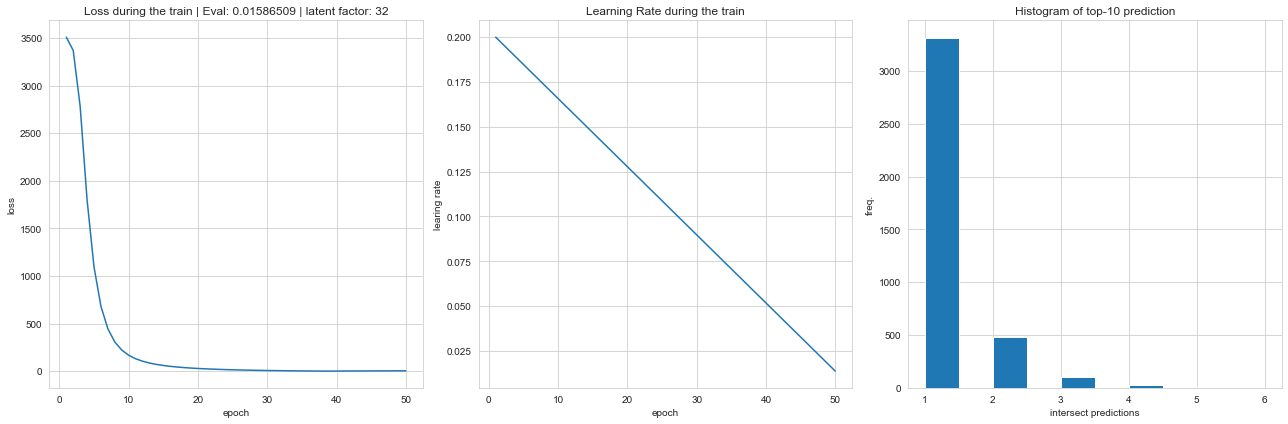

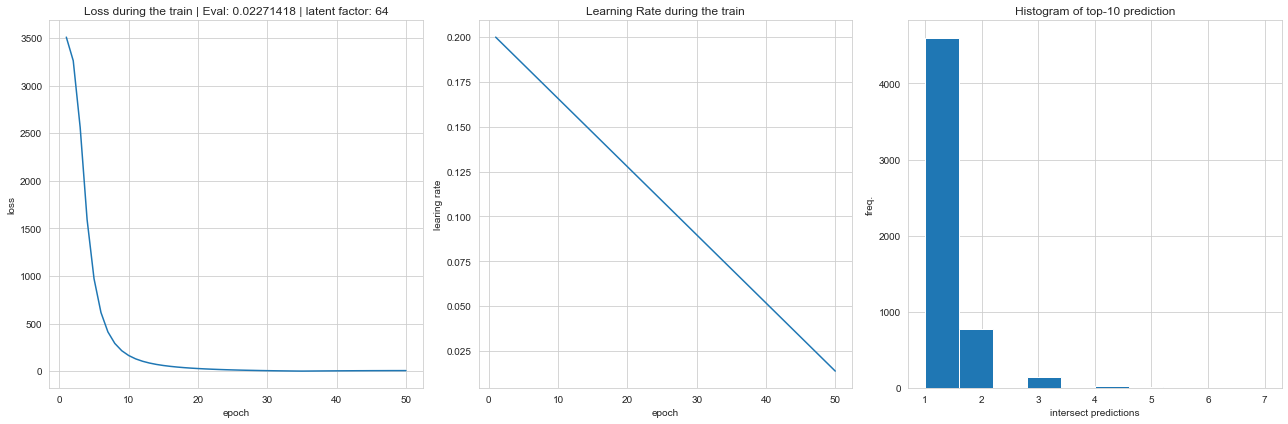

In [45]:
def report(model:MatrixFactorization,lf:int):
    H,W,I = 1,3,1
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (18,6)

    plt.subplot(H,W,I)
    I+=1
    plt.plot(list(range(1,len(model.Losses)+1)),model.Losses)
    plt.title("Loss during the train | Eval: {0} | latent factor: {1}".format(round(model.eval_value,8),lf))
    plt.ylabel("loss")
    plt.xlabel("epoch")
    

    plt.subplot(H,W,I)
    I+=1
    plt.plot(list(range(1,len(model.LRs)+1)),model.LRs)
    plt.title("Learning Rate during the train")
    plt.ylabel("learing rate")
    plt.xlabel("epoch")

    

    plt.subplot(H,W,I)
    I+=1
    plt.hist(model.eval_intersects)
    plt.title("Histogram of top-{0} prediction".format(model.topk))
    plt.ylabel("freq.")
    plt.xlabel("intersect predictions")

    plt.tight_layout()
    plt.show()
    return


report(model,32)
report(model_2,64)

29858